In [2]:
# Import necessary packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torchshow as ts
import IPython.display as ipd
import os
import pandas as pd
import torchaudio
import torchshow as ts
import librosa

In [3]:
class AvianNatureSounds(Dataset):
    def __init__(self, annotation_file=None, root_dir='./',mel_spectrogram = None,mode='wav'):
        self.annotation_file = pd.read_csv(annotation_file).sort_values('fileName')
        self.root_dir = root_dir
        self.mel_transformation = mel_spectrogram
        self.AmplitudeToDB = torchaudio.transforms.AmplitudeToDB()
        self.mode = mode


    def __len__(self):
        return len(self.annotation_file)

    def __getitem__(self, index):
        if self.mode == 'wav':
            audio_sample_path = os.path.join(self.root_dir,os.listdir(self.root_dir)[index])
            label = self.annotation_file.iloc[index]['habitat']
            signal, sr = torchaudio.load(audio_sample_path)

            return (signal, sr), label , audio_sample_path
        
        elif self.mode == 'mel':
            audio_sample_path = os.path.join(self.root_dir,os.listdir(self.root_dir)[index])
            label = self.annotation_file.iloc[index]['habitat']
            signal, sr = torchaudio.load(audio_sample_path)
            signal = self.AmplitudeToDB(self.mel_transformation(signal))

            # signal[:, 65:] = 0

            # return (signal, sr), label
            return signal, label
        
        elif self.mode == 'stft': 
            audio_sample_path = os.path.join(self.root_dir,os.listdir(self.root_dir)[index])
            label = self.annotation_file.iloc[index]['habitat']
            signal, sr = torchaudio.load(audio_sample_path)

            stft = torch.stft(signal, n_fft=1024, hop_length=512, normalized=True, return_complex=True)

            mag = self.AmplitudeToDB(torch.abs(stft))
            phase = torch.angle(stft)

            return torch.cat([mag,phase],dim=0), label
        
        elif self.mode == 'stft_mag': 
            audio_sample_path = os.path.join(self.root_dir,os.listdir(self.root_dir)[index])
            label = self.annotation_file.iloc[index]['habitat']
            signal, sr = torchaudio.load(audio_sample_path)

            stft = torch.stft(signal, n_fft=1024, hop_length=4096*2, normalized=True, return_complex=True)

            mag = self.AmplitudeToDB(torch.abs(stft))

            return mag, label
        
        elif self.mode == 'stft_phase': 
            audio_sample_path = os.path.join(self.root_dir,os.listdir(self.root_dir)[index])
            label = self.annotation_file.iloc[index]['habitat']
            signal, sr = torchaudio.load(audio_sample_path)

            stft = torch.stft(signal, n_fft=1024, hop_length=4096*2, normalized=True, return_complex=True)

            phase = torch.angle(stft)

            return phase, label


        else:
            raise NotImplementedError
    



In [4]:
class LinearInterpolation(nn.Module):
    def __init__(self, scale_factor):
        super(LinearInterpolation, self).__init__()
        self.scale_factor = scale_factor

    def forward(self, x):
        return F.interpolate(x, scale_factor=self.scale_factor, mode='bilinear', align_corners=False)



class SimpleVariationalAutoencoder(nn.Module):
    def __init__(self):
        super(SimpleVariationalAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3,stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.linsys = nn.Sequential(
            nn.Linear(56320, 4096),
            nn.ReLU(),
            nn.Linear(4096, 256))
        
        self.decoder = nn.Sequential(
            LinearInterpolation(scale_factor=2),
            nn.ConvTranspose2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            LinearInterpolation(scale_factor=2),
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
             LinearInterpolation(scale_factor=2),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            LinearInterpolation(scale_factor=2),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1)
        )
        
        self.linsys2 = nn.Sequential(
            nn.Linear(256, 4096),
            nn.ReLU(),
            nn.Linear(4096, 56320))


    def encode(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)

        print(x.shape)
        mu, sigma = self.linsys(x), self.linsys(x)

        return mu, sigma

    def decode(self, z):
        z = self.linsys2(z)
        z = z.reshape(z.shape[0],512,5,-1)
        x_recon = self.decoder(z)

        
        return x_recon

    def forward(self, x):
        mu, sigma = self.encode(x)
        z = mu + sigma * torch.randn_like(sigma)

        x_recon = self.decode(z)

        return x_recon, mu, sigma

In [5]:
model = SimpleVariationalAutoencoder()

In [8]:
# Test DataLoader: 
torchaudio.set_audio_backend(backend='sox_io')

kwargs = {
    'sample_rate': 16000,
    'n_fft': 1024,
    'hop_length': 512,
    'n_mels': 80
    # Add any other keyword arguments here
}

mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=16000,
                                     n_fft=1024,
                                     hop_length=4096*2,
                                     n_mels=80)



data = AvianNatureSounds(annotation_file='../data/AvianID_AcousticIndices/UK_AI.csv',root_dir='../data/UK_BIRD/',mel_spectrogram=mel_spectrogram,mode='stft_mag')

train_loader = DataLoader(dataset=data, batch_size=4, shuffle=True)
batch = next(iter(train_loader)) 

In [9]:
print(batch[0].shape)

torch.Size([4, 1, 513, 352])


In [10]:
model(batch[0])

torch.Size([4, 360448])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x360448 and 56320x4096)

torch.Size([80, 352])


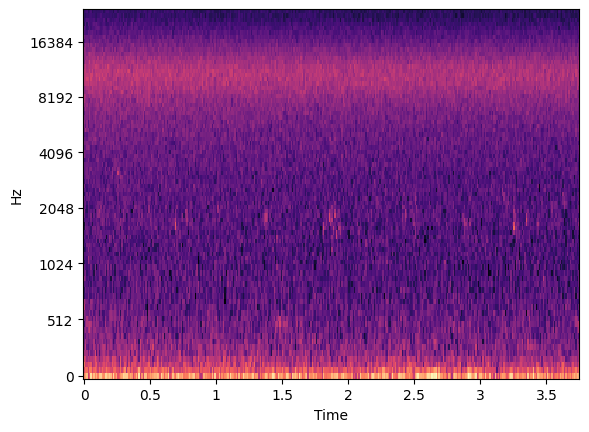

In [9]:
print(batch[0][0][0].shape)

librosa.display.specshow(batch[0][0][0].numpy(),
                         sr=48000,
                         x_axis='time',
                         y_axis='mel')

plt.show()

In [10]:
# mu, sigma = model.encode(batch[0][0])
# z = mu + sigma * torch.randn_like(sigma)

# x_recon = model.decode(z)


# x_recon[0][0].shape

# model(batch[0][0])


In [11]:
# librosa.display.specshow(x_recon[0][0].detach().numpy(),
#                          sr=48000,
#                          x_axis='time',
#                          y_axis='mel')

# plt.show()


In [13]:
# Training Loop
# Dataloader & Device
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
NUM_EPOCHS = 10
BATCH_SIZE = 64
LR_RATE = 5e-5 # kaparthy constant

#model
model = SimpleVariationalAutoencoder()
model.to(device)

# dataloader
data = AvianNatureSounds(annotation_file='../data/AvianID_AcousticIndices/UK_AI.csv',root_dir='../data/UK_BIRD/',mel_spectrogram=mel_spectrogram,mode='mel')
train_loader = DataLoader(dataset=data, batch_size=BATCH_SIZE, shuffle=True)

optimiser = optim.Adam(model.parameters(),lr=LR_RATE)
loss_fn = nn.MSELoss()

for epoch in range(NUM_EPOCHS):
    loop = tqdm(enumerate(train_loader))
    for i, (x, _) in loop:
        # Forward pass
        x = x.to(device)
        x_reconstructed, mu, sigma = model(x)

        # Compute Loss
        reconstruction_loss = loss_fn(x_reconstructed,x)
        kl_div = -torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2)-sigma.pow(2))

        # backprop
        if epoch < 25:
            loss = reconstruction_loss

        else:
            loss = reconstruction_loss + kl_div
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        loop.set_postfix(loss=loss.item())
        

32it [00:46,  1.44s/it, loss=71]  
32it [00:45,  1.41s/it, loss=40.2]
32it [04:37,  8.67s/it, loss=37.9]
32it [00:45,  1.41s/it, loss=29.3]
32it [00:45,  1.43s/it, loss=30.6]
32it [00:45,  1.42s/it, loss=33.5]
32it [00:45,  1.42s/it, loss=31.6]
32it [00:45,  1.42s/it, loss=33.9]
32it [00:45,  1.42s/it, loss=33.8]
32it [00:45,  1.42s/it, loss=33.2]


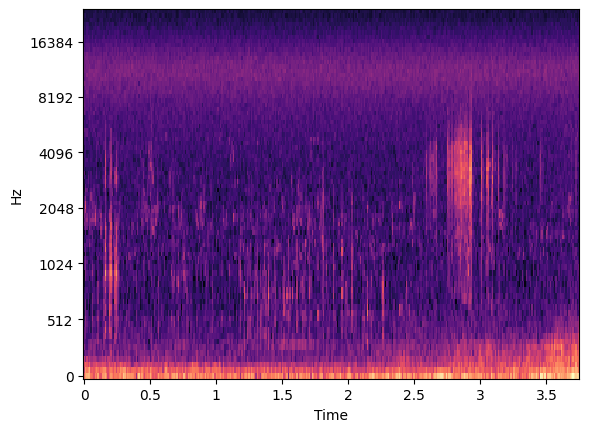

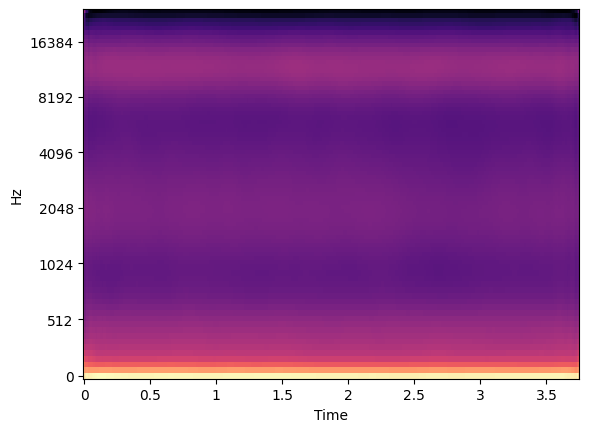

In [14]:

librosa.display.specshow(x[1][0].cpu().detach().numpy(),
                         sr=48000,
                         x_axis='time',
                         y_axis='mel')

plt.show()


atod = torchaudio.transforms.AmplitudeToDB()
librosa.display.specshow(x_reconstructed[1][0].cpu().detach().numpy(),
                         sr=48000,
                         x_axis='time',
                         y_axis='mel')

plt.show()

In [ ]:
x_reconstructed.shape